# Example of using parallel tempering 

In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jaxtyping import Float, Array
from typing import Any

from flowMC.resource.local_kernel.MALA import MALA
from flowMC.resource.buffers import Buffer
from flowMC.resource.states import State
from flowMC.strategy.take_steps import TakeSerialSteps
from flowMC.strategy.parallel_tempering import ParallelTempering
from flowMC.Sampler import Sampler
from flowMC.resource.logPDF import TemperedPDF, LogPDF


def target_dual_moon(x: Float[Array, "n_dims"], data: dict[str, Any]) -> Float:
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))

Let's setup a normal run with a MALA sampler

In [2]:
# Defining hyperparameters
n_chains = 5
rng_key = jax.random.PRNGKey(0)
n_steps = 400
step_size = 0.1
n_dims = 5
data = {"data": jnp.arange(n_dims).astype(jnp.float32)}
# Setting up resources

MALA_sampler = MALA(step_size=step_size)
positions = Buffer("positions", (n_chains, n_steps, n_dims), 1)
log_prob = Buffer("log_prob", (n_chains, n_steps), 1)
acceptance = Buffer("acceptance", (n_chains, n_steps), 1)
sampler_state = State(
    {
        "positions": "positions",
        "log_prob": "log_prob",
        "acceptance": "acceptance",
    },
    name="sampler_state",
)

resource = {
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "MALA": MALA_sampler,
    "logpdf": LogPDF(target_dual_moon, n_dims=n_dims),
    "state": sampler_state,
}

# Defining strategy

strategy = TakeSerialSteps(
    logpdf_name="logpdf",
    kernel_name="MALA",
    state_name="state",
    buffer_names=["positions", "log_prob", "acceptance"],
    n_steps=n_steps,
)

# Initializing sampler

sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resource,
    strategies={"take_steps": strategy},
    strategy_order=["take_steps"],
)

sampler.sample(
    initial_position=jax.random.normal(rng_key, (n_chains, n_dims)),
    data=data,
)

Resources and strategies provided. Ignoring resource strategy bundles.
Compiling MALA body


/home/kazewong/Work/flowMC/.venv/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'numpy.floating'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Text(0, 0.5, 'x1')

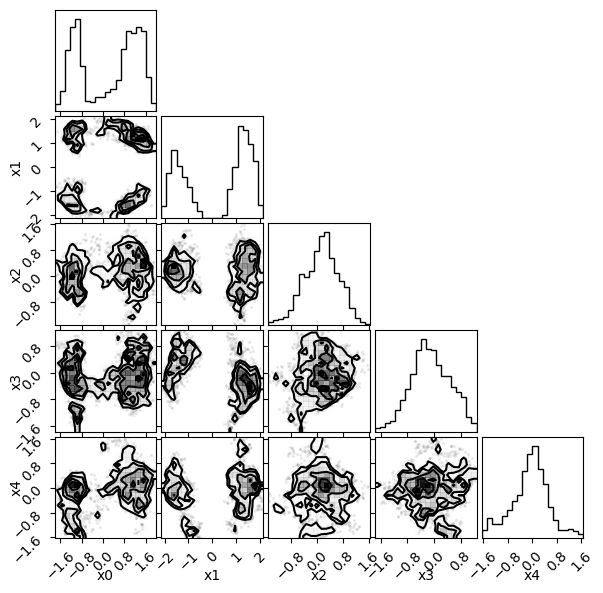

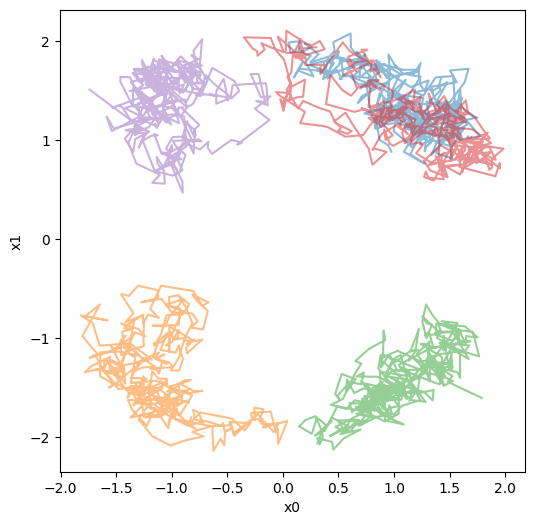

In [3]:
import corner
import numpy as np
import matplotlib.pyplot as plt

chains = sampler.resources["positions"].data

labels = [f"x{i}" for i in range(n_dims)]

# Plotting chain from flowMC
fig = plt.figure(figsize=(6, 6))
fig = corner.corner(np.array(chains.reshape(-1, n_dims)), fig=fig, labels=labels)
fig = plt.figure(figsize=(6, 6))
plt.plot(chains[:, :, 0].T, chains[:, :, 1].T, alpha=0.5)
plt.xlabel("x0")
plt.ylabel("x1")

# Now let's add parallel tempering to the mix

In [4]:
import itertools

# Defining hyperparameters
n_chains = 5
n_steps = 10
step_size = 0.1
n_dims = 5
n_temps = 5
n_loops = 40
data = {
    "data": jnp.arange(n_dims).astype(jnp.float32),
}
# Setting up resources

logpdf = LogPDF(target_dual_moon, n_dims=n_dims)

key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dims))

MALA_sampler = MALA(step_size=step_size)
positions = Buffer("positions", (n_chains, n_steps * n_loops, n_dims), 1)
log_prob = Buffer("log_prob", (n_chains, n_steps * n_loops), 1)
acceptance = Buffer("acceptance", (n_chains, n_steps * n_loops), 1)
sampler_state = State(
    {
        "positions": "positions",
        "log_prob": "log_prob",
        "acceptance": "acceptance",
        "training": True,
    },
    name="sampler_state",
)
positions.update_buffer(initial_position[:, None])
log_prob.update_buffer(
    jax.vmap(logpdf, in_axes=(0, None))(initial_position, data)[:, None]
)


take_steps = TakeSerialSteps(
    logpdf_name="logpdf",
    kernel_name="MALA",
    state_name="state",
    buffer_names=["positions", "log_prob", "acceptance"],
    n_steps=n_steps,
)

Here below are the tempering specific code to define the extra resources and strategies

In [5]:
#

key, subkey = jax.random.split(key)
tempered_logpdf = TemperedPDF(
    target_dual_moon,
    lambda x, data: jnp.array(0.0),
    n_dims=n_dims,
    n_temps=n_temps,
)
tempered_initial_position = jax.random.normal(
    subkey, shape=(n_chains, n_temps - 1, n_dims)
)
tempered_positions = Buffer("tempered_positions", (n_chains, n_temps - 1, n_dims), 2)
tempered_positions.update_buffer(tempered_initial_position)

temperatures = Buffer("temperature", (n_temps,), 0)
temperatures.update_buffer(jnp.arange(n_temps) * 5 + 1.0)

resources = {
    "logpdf": logpdf,
    "MALA": MALA_sampler,
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "tempered_logpdf": tempered_logpdf,
    "tempered_positions": tempered_positions,
    "temperatures": temperatures,
    "state": sampler_state,
}

parallel_tempering_strat = ParallelTempering(
    n_steps=n_steps,
    tempered_logpdf_name="tempered_logpdf",
    kernel_name="MALA",
    state_name="state",
    tempered_buffer_names=["tempered_positions", "temperatures"],
)

strategy_order = [["take_steps", "parallel_tempering"] for _ in range(n_loops)]

strategy_order = list(itertools.chain.from_iterable(strategy_order))

In [6]:
sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resources,
    strategies={
        "take_steps": take_steps,
        "parallel_tempering": parallel_tempering_strat,
    },
    strategy_order=strategy_order,
)

sampler.sample(
    initial_position=initial_position,
    data=data,
)

Resources and strategies provided. Ignoring resource strategy bundles.
Compiling MALA body


/home/kazewong/Work/flowMC/.venv/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'numpy.floating'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Compiling MALA body


(5, 400, 5)


Text(0, 0.5, 'x1')

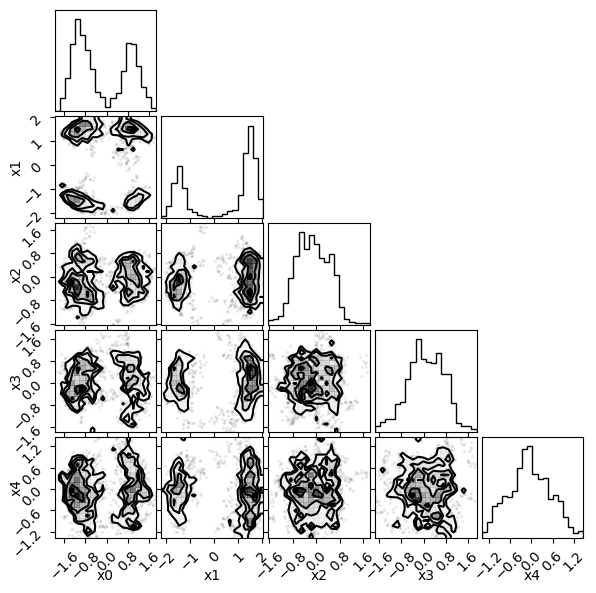

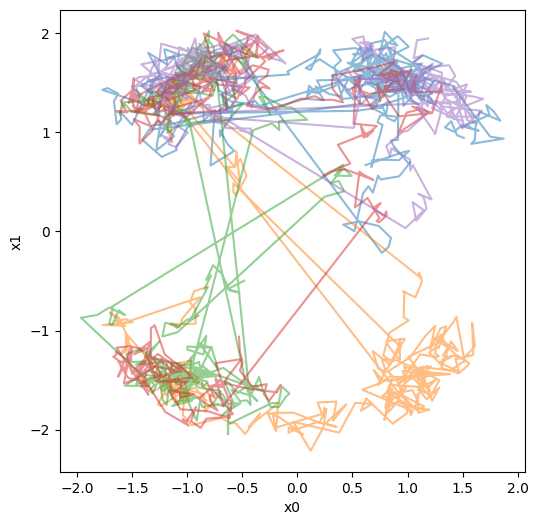

In [7]:
chains = sampler.resources["positions"].data
print(chains.shape)

labels = [f"x{i}" for i in range(n_dims)]

# Plotting chain from flowMC
fig = plt.figure(figsize=(6, 6))
fig = corner.corner(np.array(chains.reshape(-1, n_dims)), fig=fig, labels=labels)
fig = plt.figure(figsize=(6, 6))
plt.plot(chains[:, :, 0].T, chains[:, :, 1].T, alpha=0.5)
plt.xlabel("x0")
plt.ylabel("x1")

Now instead of defining your sampler from scratch, you can also use the parallel tempering bundle, which is the original flowMC sampler with the parallel tempering strategy.
The training of the normalizing flow is a computationally expensive task, so one can expect this strategy bundle to be slower than the lighter version as shown above.

In [8]:
from flowMC.resource_strategy_bundle.RQSpline_MALA_PT import RQSpline_MALA_PT_Bundle

rng_key = jax.random.PRNGKey(0)
rng_key, subkey = jax.random.split(rng_key)


n_chains = 5
n_dims = 5
bundle = RQSpline_MALA_PT_Bundle(
    subkey,
    n_chains=n_chains,
    n_dims=n_dims,
    logpdf=target_dual_moon,
    n_local_steps=2,
    n_global_steps=2,
    n_training_loops=100,
    n_production_loops=100,
    n_epochs=2,
    rq_spline_hidden_units=[32,32],
    rq_spline_n_layers=2,
    max_temperature = 20.0,
    n_temperatures=5,
    n_tempered_steps=3,
)

rng_key, subkey = jax.random.split(rng_key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dims))
sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resource_strategy_bundles=bundle,
)
sampler.sample(
    initial_position=initial_position,
    data=data,
)

Resources or strategies not provided. Using resource strategy bundles.
Compiling MALA body


/home/kazewong/Work/flowMC/.venv/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'numpy.floating'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Compiling MALA body
Compiling training step
Compiling training step
Compiling NF proposal kernel
Updated state target_positions to positions_production
Updated state target_log_prob to log_prob_production
Updated state target_local_accs to local_accs_production
Updated state target_global_accs to global_accs_production
Updated state training to False


(5, 400, 5)


Text(0, 0.5, 'x1')

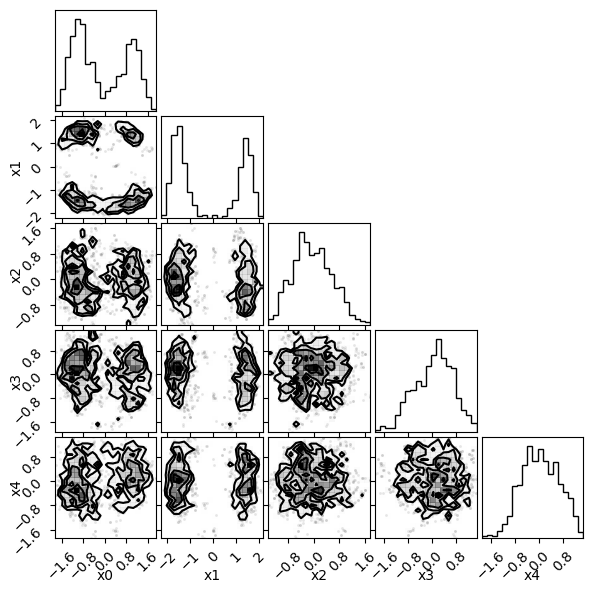

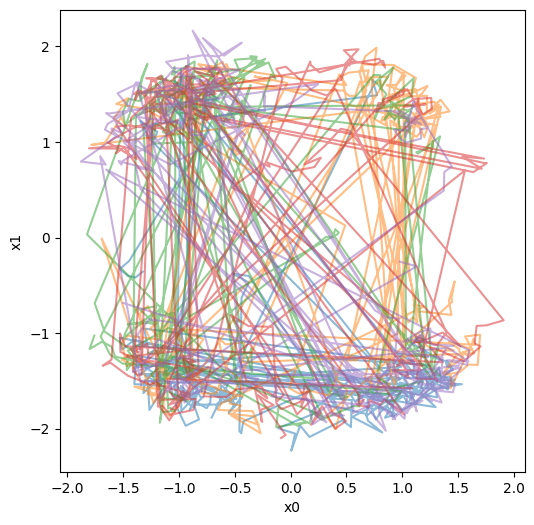

In [9]:
chains = sampler.resources['positions_training'].data
print(chains.shape)

labels = [f"x{i}" for i in range(n_dims)]

# Plotting chain from flowMC
fig = plt.figure(figsize=(6, 6))
fig = corner.corner(np.array(chains.reshape(-1, n_dims)), fig=fig, labels=labels)
fig = plt.figure(figsize=(6, 6))
plt.plot(chains[:, :, 0].T, chains[:, :, 1].T, alpha=0.5)
plt.xlabel("x0")
plt.ylabel("x1")